# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Tuesday, 3/24/2015


### Lesson 3: Reproducible Visualization Workflow

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/aKS1/tca1.png)


## Background 
You can visualize network data set using easy-to-use Cytoscape GUI and you can save the final result as a ___session file___.  But if you need to create similar visualizations, you need to repeat the manual (point-and-click) operations again.  This will be more and more time consuming process as your data sets grows.  Good news is, you can avoid it by writing your visualization workflow as Notebooks!

In [195]:
import requests
import json
from IPython.display import Image

import numpy as np
import pandas as pd

# Basic Setup
PORT_NUMBER = 1234
IP = '10.0.1.6'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Utulity to POST object
def create(param, dict_data):
    return requests.post(BASE + param, data=json.dumps(dict_data), headers=HEADERS)

def update(param, dict_data):
    return requests.put(BASE + param, data=json.dumps(dict_data), headers=HEADERS)
    
# Start from a clean slate!
requests.delete(BASE + 'session')

<Response [200]>

## Visual Style

![](http://cl.ly/aJam/visualstyles.png)

To visuaize your data with Cytoscape, you need to understand its data-to-view mapping mechanism called ___Visual Style___.

### What is a Visual Style?
__Visual Style is a collection of instructions how to map your data to visual properties (or visual variables)__.  To use it to make effective visualizations, you need to understand the following concepts.

In [196]:
# Get a list of all available Visual Styles
vs_url = BASE + 'styles'
res = requests.get(vs_url)
style_df = pd.DataFrame(res.json(), columns=['Style Name'])
style_df

,Style Name
0,default


#### Visual Properties
Visual Properties, sometimes called [visual variables](http://www.infovis-wiki.net/index.php?title=Visual_Variables) in other applications, are properties of viewable objects, such as color, shape, opacity, size, etc.

You can get the complete list of Visual Properties with the following code:

In [197]:
vps_url = BASE + 'styles/visualproperties'
print(vps_url)

# Let's make it a bit more human readable
res = requests.get(vps_url)
vp_df = pd.DataFrame(res.json(), columns=['visualProperty', 'name', 'targetDataType', 'default'])
vp_df.tail()

http://10.0.1.6:1234/v1/styles/visualproperties


,visualProperty,name,targetDataType,default
98,NODE_VISIBLE,Node Visible,CyNode,true
99,NODE_WIDTH,Node Width,CyNode,60.0
100,NODE_X_LOCATION,Node X Location,CyNode,0.0
101,NODE_Y_LOCATION,Node Y Location,CyNode,0.0
102,NODE_Z_LOCATION,Node Z Location,CyNode,0.0


#### Defaults
By default, there is no mapping from your data to Visual Properties.  __If there is no mapping for a Visual Property, default value will be used.__

In [198]:
directed_style_url = BASE + 'styles/default/defaults'
print(directed_style_url)

res = requests.get(directed_style_url)
defaults_df = pd.DataFrame(res.json()['defaults'], columns=['visualProperty', 'value'])
defaults_df.head()

http://10.0.1.6:1234/v1/styles/default/defaults


,visualProperty,value
0,EDGE_BEND,
1,EDGE_CURVED,True
2,EDGE_LABEL,
3,EDGE_LABEL_COLOR,#000000
4,EDGE_LABEL_FONT_FACE,"Dialog,plain,10"


Let's try with actual network data.

In [199]:
# Load a network file
f = open('data/yeast.json', 'r')
cyjs_network = json.load(f)
cyjs_network['data']['name'] = 'Yeast 1' 

res = create('networks', cyjs_network)
suid = res.json()['networkSUID']

# Apply Visual Style "default"
requests.get(BASE + 'apply/styles/default')
requests.get(BASE + 'apply/layouts/degree-circle/' + str(suid))

paints = defaults_df[defaults_df['visualProperty'].str.contains('COLOR')]

paints.tail(10)

,visualProperty,value
3,EDGE_LABEL_COLOR,#000000
77,NODE_FILL_COLOR,#0099CC
80,NODE_LABEL_COLOR,#FFFFFF


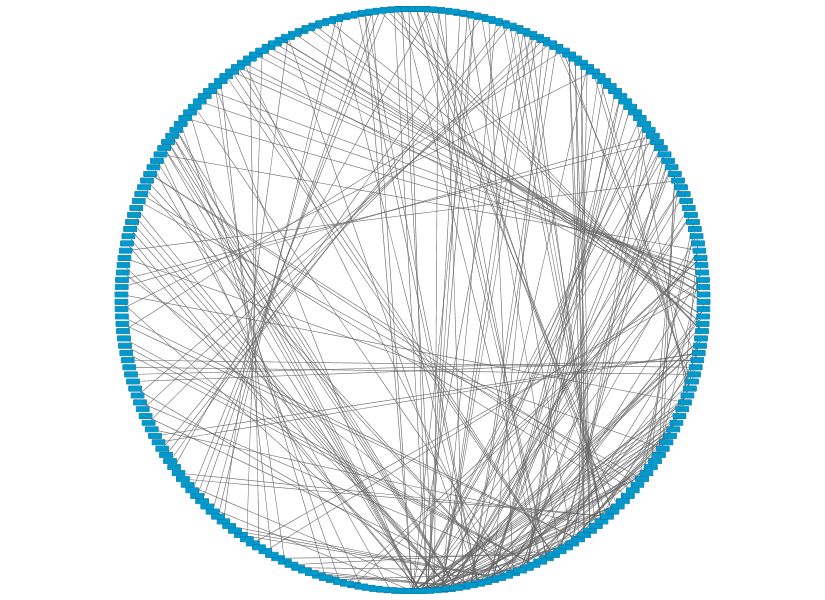

In [200]:
Image(BASE+'networks/' + str(suid) + '/views/first.png')

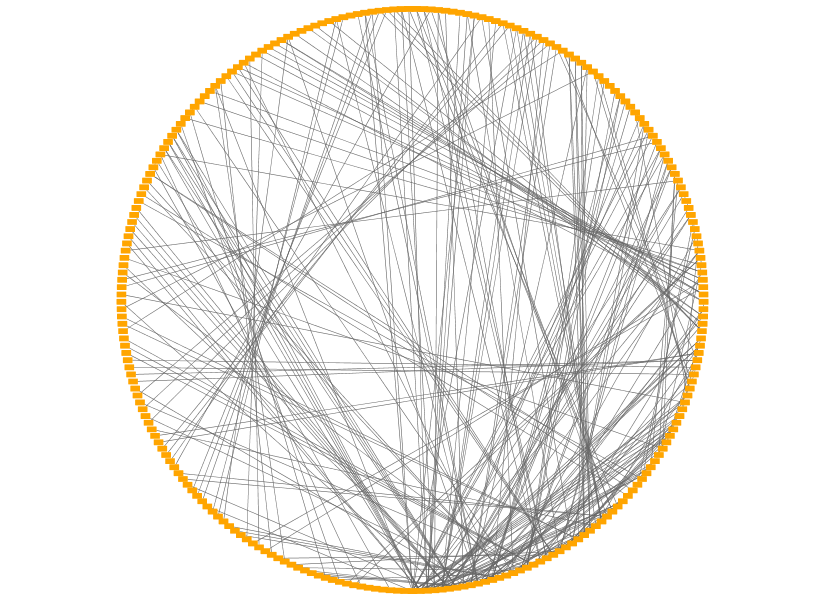

In [201]:
# Let's change some default values.
new_values = [
    {
        'visualProperty':'NODE_FILL_COLOR',
        'value': '#FFA500'
    },
    {
        'visualProperty':'NODE_BORDER_WIDTH',
        'value': 0
    },
    {
        'visualProperty':'NODE_WIDTH',
        'value': 50
    },
    {
        'visualProperty': 'EDGE_WIDTH',
        'value': 6
    }
]

update('styles/default/defaults', new_values)
Image(BASE+'networks/' + str(suid) + '/views/first.png')

### Excercise: Update default Values
* Node Color
* Edge Width
* Node Shape


In [202]:
# Write your code here...

#### Mappings
Mappings , or Visual Mapping Functions, are the actual mechanism to map data points to Visual Property values.  There are three types of mappings: discrete, continuous, and passthrough.

##### Passthrough
___Passthrough Mapping___ is the simplest mapping mechanism in Cytoscape.  It simply map values to Visual Property.  For example, if you create a node name to node label mapping, it simply passes the node name text to the Mapping Function and displays as node label. 

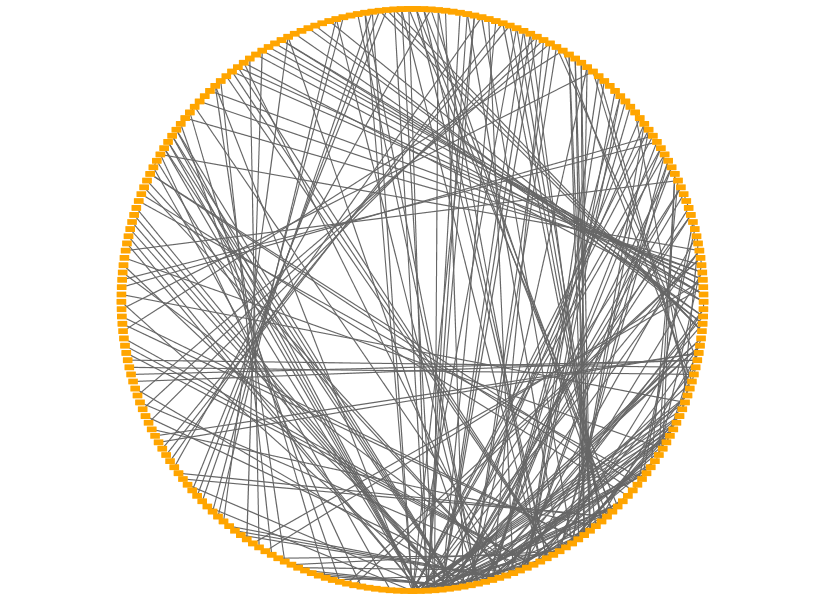

In [203]:
# Create a Passthrough mapping
new_passthrough_mapping = {
    'mappingType': 'passthrough',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_LABEL',
}

# Create a new style by POSTing the object
create('styles/default/mappings', [new_passthrough_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Discrete
Discrete mapping is the one maps discrete data points to any Visual Properties.  Here is the list of typical discrete mappings:

* Node type (gene, protein complex, small compounds, etc.) to node shape
* Node type to size
* Interaction type (inhibition / activation) to arrow shape
* Interaction detection method (Y2H, co-expression, text mining, etc.) to edge line style

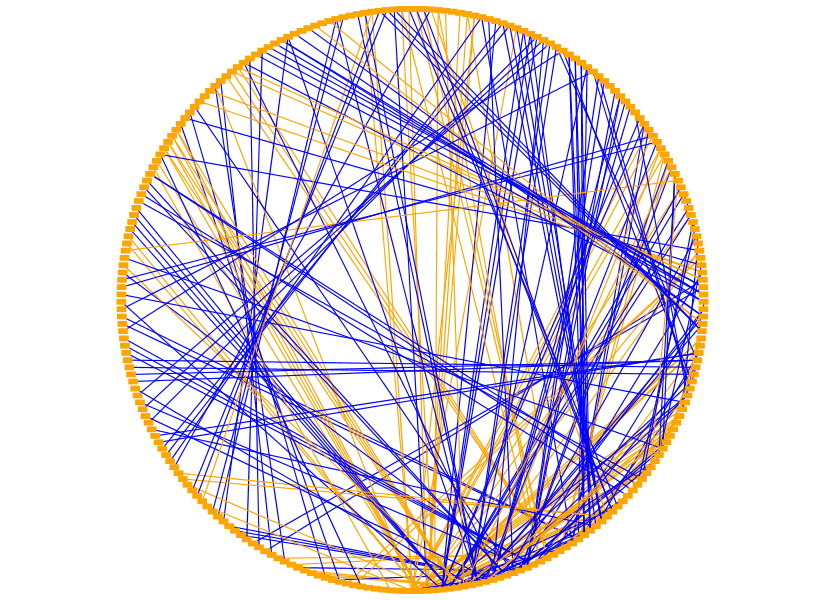

In [204]:
# Create discrete mapping
new_disc_mapping = {
    'mappingType': 'discrete',
    'mappingColumn': 'interaction',
    'mappingColumnType': 'String',
    'visualProperty': 'EDGE_STROKE_UNSELECTED_PAINT',
    'map':[
        {
            'key': 'pp',
            'value': 'blue'
        },
        {
            'key': 'pd',
            'value': 'orange'
        }
    ]
}

create('styles/default/mappings', [new_disc_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Continuous

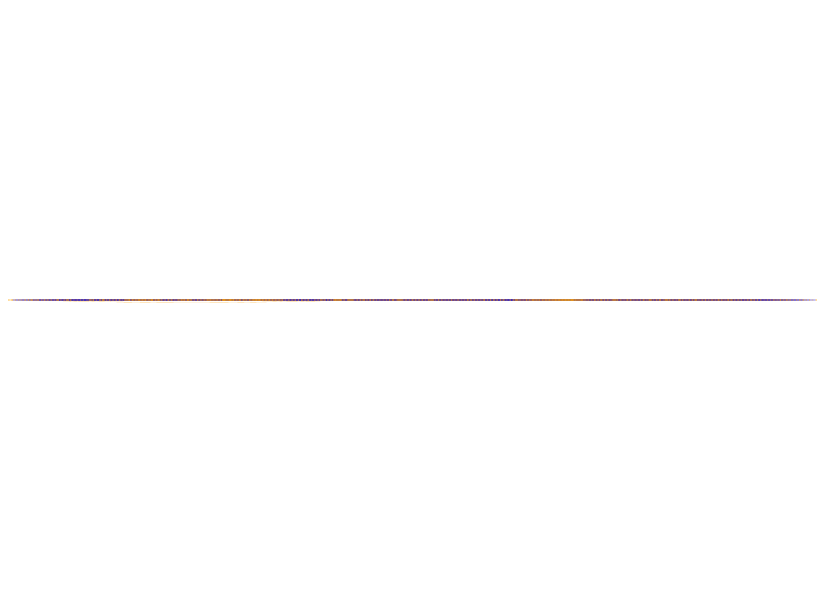

In [209]:
new_cont_mapping = {
    'mappingType': 'continuous',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_HEIGHT',
    'points':[
        {
            'value': 1,
            'lesser': '20',
            'equal': '20',
            'greater': '20'
        },
        {
            'value': 20,
            'lesser': '400',
            'equal': '400',
            'greater': 
        }
    ]
}

create('styles/default/mappings', [new_cont_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

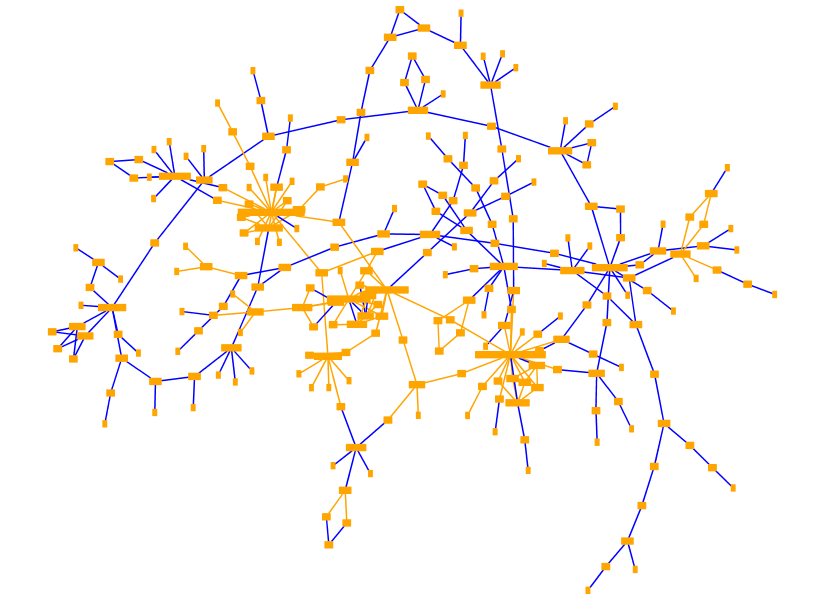

In [210]:
# Apply layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
Image(BASE+'networks/' + str(suid) + '/views/first.png')

## Discussion
OK, now you can create any mappings from Python.  But editing code like this manyally is a pain...  

### _Don't repeat yourself!_
The true power of __workflow-as-code__ is its reproducibility.  You can easily reuse your existing code and design to other data sets.

In [206]:
def get_basic_mapping(map_type, column, column_type, vp):
    new_mapping = {
         'mappingType': map_type,
        'mappingColumn': column,
        'mappingColumnType': column_type,
        'visualProperty': vp,
    }
    return new_mapping
    
def get_discrete_mapping(column, column_type, vp):
    mapping = get_basic_mapping('discrete', column, column_type, vp)
    mapping['map'] = []
    return mapping

def get_continuous_mapping(column, column_type, vp):
    mapping = get_basic_mapping('continuous', column, column_type, vp)
    mapping['points'] = []
    return mapping

def get_passthrough_mapping(column, column_type, vp):
    return get_basic_mapping('passthrough', column, column_type, vp)

#### Is it worth wrting a new Python package?


### Directly Edit the View
In some cases, you may want to edit the view directly.  Typical example is node layout.

### Write your own layout algorithm

In [207]:
res = requests.get(BASE + 'networks/' + str(suid) + '/views')
view_id = res.json()[0]
view_id

res = requests.get(BASE + 'networks/' + str(suid) + '/views/' + str(view_id) + '/nodes')
res = requests.get(BASE + 'networks/' + str(suid) + '/nodes')
node_suids = res.json()
node_suids

[40130,
 40131,
 40132,
 40133,
 40134,
 40135,
 40136,
 40137,
 40138,
 40139,
 40140,
 40141,
 40142,
 40143,
 40144,
 40145,
 40146,
 40147,
 40148,
 40149,
 40150,
 40151,
 40152,
 40153,
 40154,
 40155,
 40156,
 40157,
 40158,
 40159,
 40160,
 40161,
 40162,
 40163,
 40164,
 40165,
 40166,
 40167,
 40168,
 40169,
 40170,
 40171,
 40172,
 40173,
 40174,
 40175,
 40176,
 40177,
 40178,
 40179,
 40180,
 40181,
 40182,
 40183,
 40184,
 40185,
 40186,
 40187,
 40188,
 40189,
 40190,
 40191,
 40192,
 40193,
 40194,
 40195,
 40196,
 40197,
 40198,
 40199,
 40200,
 40201,
 40202,
 40203,
 40204,
 40205,
 40206,
 40207,
 40208,
 40209,
 40210,
 40211,
 40212,
 40213,
 40214,
 40215,
 40216,
 40217,
 40218,
 40219,
 40220,
 40221,
 40222,
 40223,
 40224,
 40225,
 40226,
 40227,
 40228,
 40229,
 40230,
 40231,
 40232,
 40233,
 40234,
 40235,
 40236,
 40237,
 40238,
 40239,
 40240,
 40241,
 40242,
 40243,
 40244,
 40245,
 40246,
 40247,
 40248,
 40249,
 40250,
 40251,
 40252,
 40253,
 40254,


In [208]:
def linear_layout(suid, node_list):
    # Node X Position = size
    position_x = []
    position_y = []
    start_pos = 0
    for node in node_list:
        x = {
            'SUID': node,
            'view':[
                {
                    'visualProperty': 'NODE_X_LOCATION',
                    'value': start_pos
                },
                {
                    'visualProperty': 'NODE_Y_LOCATION',
                    'value': 0
                }
            ]
        }
        position_x.append(x)
        start_pos = start_pos+100

#     print(position_x)
    return position_x
    

posx = linear_layout(view_id, node_suids)    
res = requests.put(BASE + 'networks/' + str(suid) + '/views/' + str(view_id) + '/nodes', data=json.dumps(posx),  headers=HEADERS)
res

<Response [204]>